##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 転移学習とファインチューニング

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/transfer_learning.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、転移学習を使用して、事前トレーニング済みネットワークから猫や犬の画像を分類する方法を紹介します。

事前トレーニング済みモデルは、通常は大規模な画像分類タスクなどの大規模なデータセットで事前トレーニング済みの保存されたネットワークです。事前トレーニング済みモデルをそのまま使用したり、転移学習を使用してこのモデルを任意のタスクにカスタマイズしたりすることができます。

画像分類のための転移学習の背後にある考え方は、モデルが大規模かつ十分に一般的なデータセットでトレーニングされていれば、そのモデルは視覚世界の一般的なモデルとして効果的に機能するというものです。それにより、最初から大規模なデータセット上で大規模なモデルをトレーニングを行わずに、これらの学習した特徴マップを活用することができます。

このノートブックでは、トレーニング済みモデルをカスタマイズする 2 つの方法を試します。

1. 特徴抽出：前のネットワークで学習した表現を使用して、新しいサンプルから意味のある特徴を抽出します。事前トレーニング済みモデルの上に新規にトレーニングされる新しい分類器を追加するだけで、データセットで前に学習した特徴マップを再利用できるようになります。

モデル全体を（再）トレーニングする必要はありません。ベースとなる畳み込みネットワークには、画像分類に一般的に有用な特徴がすでに含まれています。ただし、事前トレーニング済みモデルの最後の分類部分は元の分類タスクに固有で、その後はモデルがトレーニングされたクラスのセットに固有です。

1. ファインチューニング：凍結された基本モデルの最上位レイヤーのいくつかを解凍し、新たに追加された分類器レイヤーと解凍した基本モデルの最後のレイヤーの両方を合わせてトレーニングします。これにより、基本モデルの高次の特徴表現を「ファインチューニング」して、特定のタスクにより関連性を持たせることができます。

一般的な機械学習のワークフローに従います。

1. データを調べ、理解する
2. 入力パイプラインを構築し、この場合は Keras ImageDataGenerator を使用する
3. モデルを作成する
    - 事前トレーニング済みの基本モデル（および事前トレーニング済みの重み）を読み込む
    - 分類レイヤーを上に重ねる
4. モデルをトレーニングする
5. モデルを評価する


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-01-11 22:22:38.312406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 22:22:38.312449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 22:22:38.314026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## データの前処理をする

### データをダウンロードする

このチュートリアルでは、数千枚の犬猫の画像を含むデータセットを使用します。画像を含む zip ファイルをダウンロードして解凍した後、`tf.keras.utils.image_dataset_from_directory` ユーティリティを使用して `tf.data.Dataset` を作成し、トレーニングと検証を行います。画像の読み込みに関する詳細は、この[チュートリアル](https://www.tensorflow.org/tutorials/load_data/images)をご覧ください。

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 0s

 4202496/68606236 [>.............................] - ETA: 0s

 9347072/68606236 [===>..........................] - ETA: 0s

16138240/68606236 [======>.......................] - ETA: 0s

23257088/68606236 [=========>....................] - ETA: 0s

32088064/68606236 [=============>................] - ETA: 0s

44638208/68606236 [==================>...........] - ETA: 0s

53919744/68606236 [======================>.......] - ETA: 0s

65814528/68606236 [===========================>..] - ETA: 0s

68606236/68606236 [==============================] - 0s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


トレーニングセットの最初の 9 枚の画像とラベルを表示します。

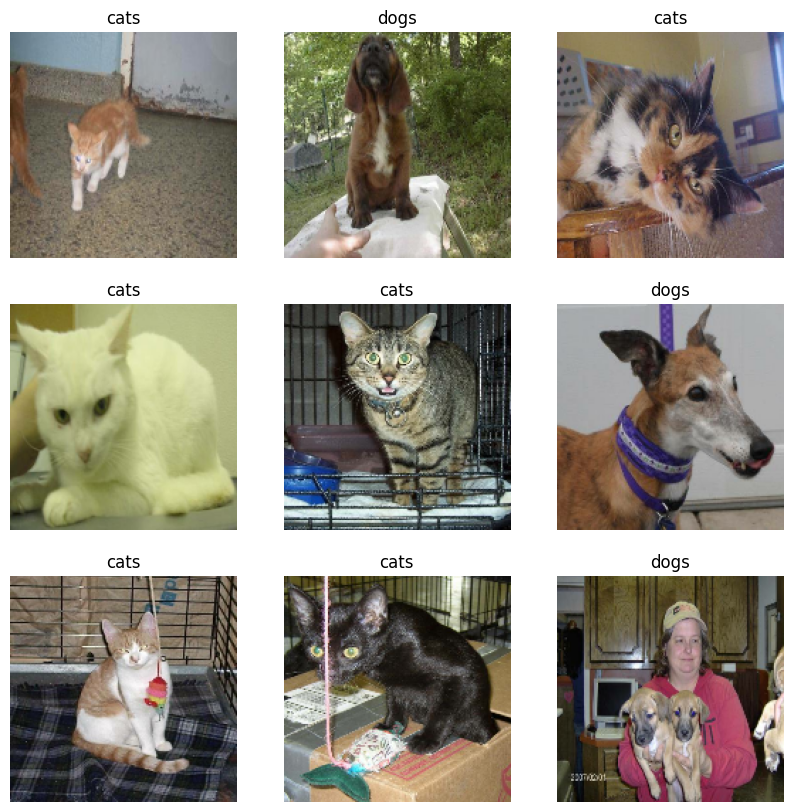

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

元のデータセットにはテストセットが含まれていないので、テストセットを作成します。作成には、`tf.data.experimental.cardinality` を使用して検証セットで利用可能なデータのバッチ数を調べ、そのうちの 20％ をテストセットに移動します。

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### パフォーマンスのためにデータセットを構成する

バッファ付きプリフェッチを使用して、I/O のブロッキングなしでディスクから画像を読み込みます。この手法の詳細については[データパフォーマンス](https://www.tensorflow.org/guide/data_performance)ガイドをご覧ください。

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### データ増強を使用する

大規模な画像データセットを持っていない場合には、回転や水平反転など、ランダムでありながら現実的な変換をトレーニング画像に適用し、サンプルを人為的に多様化することをお勧めします。これによって、トレーニングデータのさまざまな側面にモデルを露出させることができ、[過適合](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)を遅らせることができます。データ増強についての詳細は、この[チュートリアル](https://www.tensorflow.org/tutorials/images/data_augmentation)をご覧ください。

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

注意: これらのレイヤーは、トレーニング中に `Model.fit` を呼び出した場合にのみアクティブです。モデルが `Model.evaluate`、`Model.predict`、または `Model.call` の推論モードで使用されている場合には非アクティブです。

これらのレイヤーを同じ画像に繰り返して適用し、結果を見てみましょう。

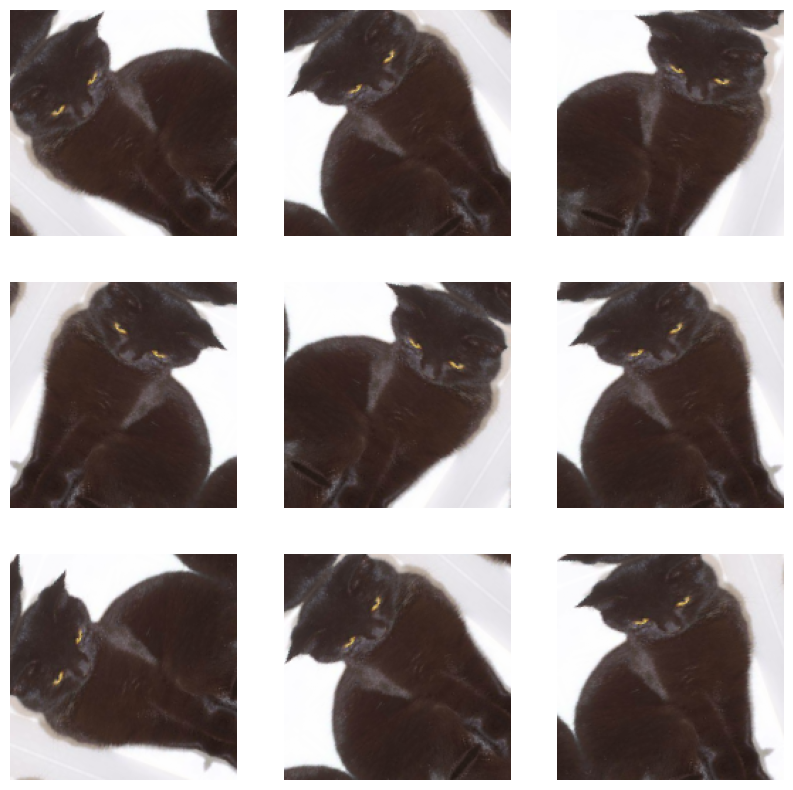

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### ピクセル値をリスケールする

すぐに `tf.keras.applications.MobileNetV2` をダウンロードして、基本モデルとして使用します。このモデルはピクセル値 `[-1,1]` を想定していますが、この時点での画像のピクセル値は `[0, 255]` です。ピクセル値のリスケールには、モデルに含まれる前処理のメソッドを使用します。

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

注意: 別の方法として、`tf.keras.layers.Rescaling` を使用して、ピクセル値を `[0, 255]` から `[-1, 1]` にリスケールすることも可能です。

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

注意: 他の `tf.keras.applications` を使用する場合は、API ドキュメントを確認してピクセル値が `[-1,1]` または `[0,1]` を要求しているか確かめるか、あるいは含まれている関数 `preprocess_input` を使用します。

## 事前トレーニング済み畳み込みニューラルネットワークから基本モデルを作成する

Google が開発した **MobileNet V2** モデルから基本モデルを作成します。これは、140 万枚の画像と 1000 クラスで構成された大規模データセットである ImageNet データセットによる事前トレーニング済みのモデルです。ImageNet は、`jackfruit` や `syringe` のような多彩なカテゴリを持つ研究用トレーニングデータセットです。この知識の基盤が、特定のデータセットから猫と犬を分類するのに有用になります。

まず、特徴抽出に使用する MobileNet V2 のレイヤーを選択する必要があります。最後の分類レイヤー（ほとんどの機械学習モデルの図では、下から上に向かうため、「上」にあります）はあまり役には立ちません。 その代わりに、平坦化演算の前の最後のレイヤーに依存するのが一般的です。このレイヤーは「ボトルネックレイヤー」と呼ばれます。ボトルネックレイヤーの特徴には、最終/最上位レイヤーよりも一般性が保持されています。

はじめに、ImageNet でトレーニングした重みで事前に読み込んだ MobileNet V2 モデルをインスタンス化します。引数 **include_top=False** を指定して、上位の分類レイヤーを含まない、特徴抽出に理想的なネットワークを読み込みます。

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


この特徴抽出器は、各 `160x160x3` の画像を `5x5x1280` の特徴ブロックに変換します。 これで画像のバッチ例がどうなるかを見てみましょう。

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 特徴を抽出する

このステップでは、前のステップで作成した畳み込みベースを凍結させ、特徴抽出器として使用します。さらに、その上に分類器を追加して、最上位の分類器のトレーニングを行います。

### 畳み込みベースを凍結させる

モデルをコンパイルしてトレーニングする前に、畳み込みベースを凍結させることは重要です。(layer.trainable = False と設定して) 凍結させると、トレーニング中に特定のレイヤーの重みは更新されなくなります。MobileNet V2 には多くのレイヤーがありますが、モデル全体の `trainable` フラグを False に設定すれば、すべてのレイヤーをまとめて凍結することができます。

In [16]:
base_model.trainable = False

### BatchNormalization レイヤーに関する重要な注意事項

多くのモデルには `tf.keras.layers.BatchNormalization` レイヤーが含まれています。このレイヤーは特殊なケースで、ファインチューニングのコンテキストに注意を払う必要があります。このチュートリアルでも後ほど説明します。

`layer.trainable = False` と設定する場合、`BatchNormalization` レイヤーは推論モードで実行されるため、その平均と分散統計は更新されません。

ファインチューニングを行うために BatchNormalization（バッチ正規化）レイヤーを含んだモデルを解凍する場合には、基本モデルを呼び出す際に `training = False` を渡して BatchNormalization レイヤーを推論モードにしておく必要があります。そうしないと、トレーニング不可能な重みに更新が適用され、モデルが学習したものを破壊してしまいます。

詳細については、[転移学習ガイド](https://www.tensorflow.org/guide/keras/transfer_learning)をご覧ください。

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            


 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             


 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               


 on)                                                                                              


 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']            


 expanded_conv_depthwise (D  (None, 80, 80, 32)           288       ['Conv1_relu[0][0]']          


 epthwiseConv2D)                                                                                  


 expanded_conv_depthwise_BN  (None, 80, 80, 32)           128       ['expanded_conv_depthwise[0][0


  (BatchNormalization)                                              ]']                           


 expanded_conv_depthwise_re  (None, 80, 80, 32)           0         ['expanded_conv_depthwise_BN[0


 lu (ReLU)                                                          ][0]']                        


 expanded_conv_project (Con  (None, 80, 80, 16)           512       ['expanded_conv_depthwise_relu


 v2D)                                                               [0][0]']                      


 expanded_conv_project_BN (  (None, 80, 80, 16)           64        ['expanded_conv_project[0][0]'


 BatchNormalization)                                                ]                             


 block_1_expand (Conv2D)     (None, 80, 80, 96)           1536      ['expanded_conv_project_BN[0][


                                                                    0]']                          


 block_1_expand_BN (BatchNo  (None, 80, 80, 96)           384       ['block_1_expand[0][0]']      


 rmalization)                                                                                     


 block_1_expand_relu (ReLU)  (None, 80, 80, 96)           0         ['block_1_expand_BN[0][0]']   


 block_1_pad (ZeroPadding2D  (None, 81, 81, 96)           0         ['block_1_expand_relu[0][0]'] 


 )                                                                                                


 block_1_depthwise (Depthwi  (None, 40, 40, 96)           864       ['block_1_pad[0][0]']         


 seConv2D)                                                                                        


 block_1_depthwise_BN (Batc  (None, 40, 40, 96)           384       ['block_1_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_1_depthwise_relu (Re  (None, 40, 40, 96)           0         ['block_1_depthwise_BN[0][0]']


 LU)                                                                                              


 block_1_project (Conv2D)    (None, 40, 40, 24)           2304      ['block_1_depthwise_relu[0][0]


                                                                    ']                            


 block_1_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_1_project[0][0]']     


 ormalization)                                                                                    


 block_2_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_1_project_BN[0][0]']  


 block_2_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_2_expand[0][0]']      


 rmalization)                                                                                     


 block_2_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_2_expand_BN[0][0]']   


 block_2_depthwise (Depthwi  (None, 40, 40, 144)          1296      ['block_2_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_2_depthwise_BN (Batc  (None, 40, 40, 144)          576       ['block_2_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_2_depthwise_relu (Re  (None, 40, 40, 144)          0         ['block_2_depthwise_BN[0][0]']


 LU)                                                                                              


 block_2_project (Conv2D)    (None, 40, 40, 24)           3456      ['block_2_depthwise_relu[0][0]


                                                                    ']                            


 block_2_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_2_project[0][0]']     


 ormalization)                                                                                    


 block_2_add (Add)           (None, 40, 40, 24)           0         ['block_1_project_BN[0][0]',  


                                                                     'block_2_project_BN[0][0]']  


 block_3_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_2_add[0][0]']         


 block_3_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_3_expand[0][0]']      


 rmalization)                                                                                     


 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   


 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 


 )                                                                                                


 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         


 seConv2D)                                                                                        


 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_3_depthwise_relu (Re  (None, 20, 20, 144)          0         ['block_3_depthwise_BN[0][0]']


 LU)                                                                                              


 block_3_project (Conv2D)    (None, 20, 20, 32)           4608      ['block_3_depthwise_relu[0][0]


                                                                    ']                            


 block_3_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_3_project[0][0]']     


 ormalization)                                                                                    


 block_4_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_3_project_BN[0][0]']  


 block_4_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_4_expand[0][0]']      


 rmalization)                                                                                     


 block_4_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_4_expand_BN[0][0]']   


 block_4_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_4_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_4_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_4_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_4_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_4_depthwise_BN[0][0]']


 LU)                                                                                              


 block_4_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_4_depthwise_relu[0][0]


                                                                    ']                            


 block_4_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_4_project[0][0]']     


 ormalization)                                                                                    


 block_4_add (Add)           (None, 20, 20, 32)           0         ['block_3_project_BN[0][0]',  


                                                                     'block_4_project_BN[0][0]']  


 block_5_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_4_add[0][0]']         


 block_5_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_5_expand[0][0]']      


 rmalization)                                                                                     


 block_5_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_5_expand_BN[0][0]']   


 block_5_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_5_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_5_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_5_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_5_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_5_depthwise_BN[0][0]']


 LU)                                                                                              


 block_5_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_5_depthwise_relu[0][0]


                                                                    ']                            


 block_5_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_5_project[0][0]']     


 ormalization)                                                                                    


 block_5_add (Add)           (None, 20, 20, 32)           0         ['block_4_add[0][0]',         


                                                                     'block_5_project_BN[0][0]']  


 block_6_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_5_add[0][0]']         


 block_6_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_6_expand[0][0]']      


 rmalization)                                                                                     


 block_6_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_6_expand_BN[0][0]']   


 block_6_pad (ZeroPadding2D  (None, 21, 21, 192)          0         ['block_6_expand_relu[0][0]'] 


 )                                                                                                


 block_6_depthwise (Depthwi  (None, 10, 10, 192)          1728      ['block_6_pad[0][0]']         


 seConv2D)                                                                                        


 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']


 LU)                                                                                              


 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]


                                                                    ']                            


 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     


 ormalization)                                                                                    


 block_7_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_6_project_BN[0][0]']  


 block_7_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_7_expand[0][0]']      


 rmalization)                                                                                     


 block_7_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_7_expand_BN[0][0]']   


 block_7_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_7_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_7_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_7_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_7_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_7_depthwise_BN[0][0]']


 LU)                                                                                              


 block_7_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_7_depthwise_relu[0][0]


                                                                    ']                            


 block_7_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_7_project[0][0]']     


 ormalization)                                                                                    


 block_7_add (Add)           (None, 10, 10, 64)           0         ['block_6_project_BN[0][0]',  


                                                                     'block_7_project_BN[0][0]']  


 block_8_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_7_add[0][0]']         


 block_8_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_8_expand[0][0]']      


 rmalization)                                                                                     


 block_8_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_8_expand_BN[0][0]']   


 block_8_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_8_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_8_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_8_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_8_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_8_depthwise_BN[0][0]']


 LU)                                                                                              


 block_8_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_8_depthwise_relu[0][0]


                                                                    ']                            


 block_8_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_8_project[0][0]']     


 ormalization)                                                                                    


 block_8_add (Add)           (None, 10, 10, 64)           0         ['block_7_add[0][0]',         


                                                                     'block_8_project_BN[0][0]']  


 block_9_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_8_add[0][0]']         


 block_9_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_9_expand[0][0]']      


 rmalization)                                                                                     


 block_9_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_9_expand_BN[0][0]']   


 block_9_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_9_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_9_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_9_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_9_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_9_depthwise_BN[0][0]']


 LU)                                                                                              


 block_9_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_9_depthwise_relu[0][0]


                                                                    ']                            


 block_9_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_9_project[0][0]']     


 ormalization)                                                                                    


 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         


                                                                     'block_9_project_BN[0][0]']  


 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         


 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     


 ormalization)                                                                                    


 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  


 )                                                                                                


 block_10_depthwise (Depthw  (None, 10, 10, 384)          3456      ['block_10_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_10_depthwise_BN (Bat  (None, 10, 10, 384)          1536      ['block_10_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_10_depthwise_relu (R  (None, 10, 10, 384)          0         ['block_10_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_10_project (Conv2D)   (None, 10, 10, 96)           36864     ['block_10_depthwise_relu[0][0


                                                                    ]']                           


 block_10_project_BN (Batch  (None, 10, 10, 96)           384       ['block_10_project[0][0]']    


 Normalization)                                                                                   


 block_11_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_10_project_BN[0][0]'] 


 block_11_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_11_expand[0][0]']     


 ormalization)                                                                                    


 block_11_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_11_expand_BN[0][0]']  


 )                                                                                                


 block_11_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_11_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_11_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_11_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_11_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_11_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_11_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_11_depthwise_relu[0][0


                                                                    ]']                           


 block_11_project_BN (Batch  (None, 10, 10, 96)           384       ['block_11_project[0][0]']    


 Normalization)                                                                                   


 block_11_add (Add)          (None, 10, 10, 96)           0         ['block_10_project_BN[0][0]', 


                                                                     'block_11_project_BN[0][0]'] 


 block_12_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_11_add[0][0]']        


 block_12_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_12_expand[0][0]']     


 ormalization)                                                                                    


 block_12_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_12_expand_BN[0][0]']  


 )                                                                                                


 block_12_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_12_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_12_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_12_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_12_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_12_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_12_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_12_depthwise_relu[0][0


                                                                    ]']                           


 block_12_project_BN (Batch  (None, 10, 10, 96)           384       ['block_12_project[0][0]']    


 Normalization)                                                                                   


 block_12_add (Add)          (None, 10, 10, 96)           0         ['block_11_add[0][0]',        


                                                                     'block_12_project_BN[0][0]'] 


 block_13_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_12_add[0][0]']        


 block_13_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_13_expand[0][0]']     


 ormalization)                                                                                    


 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  


 )                                                                                                


 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']


 D)                                                                                               


 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        


 iseConv2D)                                                                                       


 block_13_depthwise_BN (Bat  (None, 5, 5, 576)            2304      ['block_13_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_13_depthwise_relu (R  (None, 5, 5, 576)            0         ['block_13_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_13_project (Conv2D)   (None, 5, 5, 160)            92160     ['block_13_depthwise_relu[0][0


                                                                    ]']                           


 block_13_project_BN (Batch  (None, 5, 5, 160)            640       ['block_13_project[0][0]']    


 Normalization)                                                                                   


 block_14_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_13_project_BN[0][0]'] 


 block_14_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_14_expand[0][0]']     


 ormalization)                                                                                    


 block_14_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_14_expand_BN[0][0]']  


 )                                                                                                


 block_14_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_14_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_14_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_14_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_14_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_14_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_14_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_14_depthwise_relu[0][0


                                                                    ]']                           


 block_14_project_BN (Batch  (None, 5, 5, 160)            640       ['block_14_project[0][0]']    


 Normalization)                                                                                   


 block_14_add (Add)          (None, 5, 5, 160)            0         ['block_13_project_BN[0][0]', 


                                                                     'block_14_project_BN[0][0]'] 


 block_15_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_14_add[0][0]']        


 block_15_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_15_expand[0][0]']     


 ormalization)                                                                                    


 block_15_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_15_expand_BN[0][0]']  


 )                                                                                                


 block_15_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_15_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_15_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_15_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_15_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_15_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_15_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_15_depthwise_relu[0][0


                                                                    ]']                           


 block_15_project_BN (Batch  (None, 5, 5, 160)            640       ['block_15_project[0][0]']    


 Normalization)                                                                                   


 block_15_add (Add)          (None, 5, 5, 160)            0         ['block_14_add[0][0]',        


                                                                     'block_15_project_BN[0][0]'] 


 block_16_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_15_add[0][0]']        


 block_16_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_16_expand[0][0]']     


 ormalization)                                                                                    


 block_16_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_16_expand_BN[0][0]']  


 )                                                                                                


 block_16_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_16_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0


                                                                    ]']                           


 block_16_project_BN (Batch  (None, 5, 5, 320)            1280      ['block_16_project[0][0]']    


 Normalization)                                                                                   


 Conv_1 (Conv2D)             (None, 5, 5, 1280)           409600    ['block_16_project_BN[0][0]'] 


 Conv_1_bn (BatchNormalizat  (None, 5, 5, 1280)           5120      ['Conv_1[0][0]']              


 ion)                                                                                             


 out_relu (ReLU)             (None, 5, 5, 1280)           0         ['Conv_1_bn[0][0]']           


Total params: 2257984 (8.61 MB)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 2257984 (8.61 MB)


__________________________________________________________________________________________________


### 分類ヘッドを追加する

特徴ブロックから予測値を生成するには、`f.keras.layers.GlobalAveragePooling2D` レイヤーを使用して `5x5` 空間の空間位置を平均化し、特徴を画像ごとに単一の1280要素ベクトルに変換します。

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


`tf.keras.layers.Dense` レイヤーを適用して、これらの特徴を画像ごとに単一の予測値に変換します。この予測は `logit` または未加工の予測値として扱われるため、ここで活性化関数は必要ありません。 正の数はクラス 1 を予測し、負の数はクラス 0 を予測します。

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


[Keras Functional API](https://www.tensorflow.org/guide/keras/functional) を使用して、データ増強、リスケール、base_model、特徴抽出レイヤーを連結してモデルを構築します。前に触れたように、モデルには BatchNormalization レイヤーが含まれているため、training=False を使用します。

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1281 (5.00 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


MobileNet の 800 万個以上のパラメータは凍結されていますが、Dense レイヤーには 1200 個の*トレーニング可能な*パラメータがあります。これらは 2 つの `tf.Variable` オブジェクトである、重みとバイアスに分割されます。

In [22]:
len(model.trainable_variables)

2

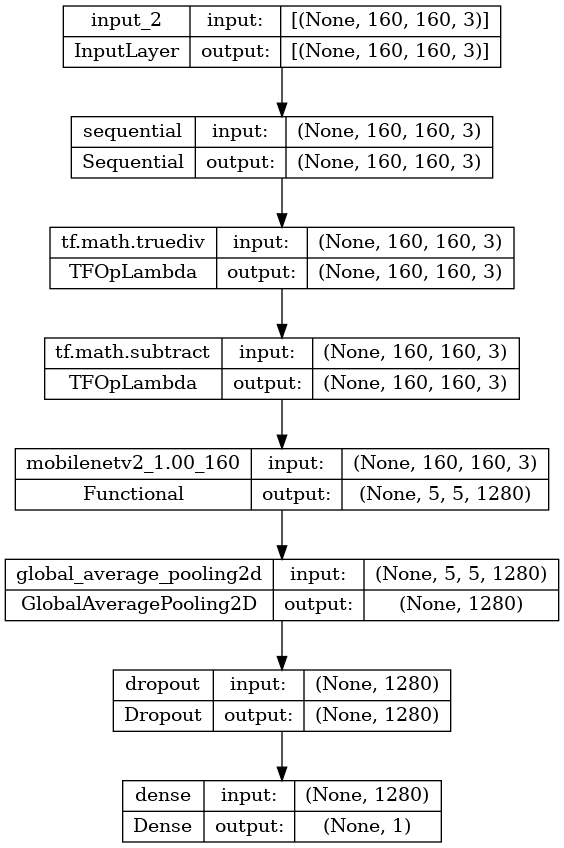

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### モデルをコンパイルする

トレーニングする前にモデルをコンパイルします。2 つのクラスがあり、モデルが線形出力を提供するので、`from_logits=True` で `tf.keras.losses.BinaryCrossentropy` を使用します。

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### モデルをトレーニングする

10 エポックのトレーニング後は、検証セットの精度が最大 96%になります。


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 56s - loss: 0.8438 - accuracy: 0.5312

 4/26 [===>..........................] - ETA: 0s - loss: 0.7887 - accuracy: 0.5469 

 7/26 [=======>......................] - ETA: 0s - loss: 0.8343 - accuracy: 0.5312

10/26 [==========>...................] - ETA: 0s - loss: 0.8342 - accuracy: 0.5125

13/26 [==============>...............] - ETA: 0s - loss: 0.8679 - accuracy: 0.4880

16/26 [=================>............] - ETA: 0s - loss: 0.8644 - accuracy: 0.4844

19/26 [====================>.........] - ETA: 0s - loss: 0.8748 - accuracy: 0.4770

22/26 [========================>.....] - ETA: 0s - loss: 0.8797 - accuracy: 0.4815

25/26 [===========================>..] - ETA: 0s - loss: 0.8719 - accuracy: 0.4875

26/26 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.4864

26/26 [==============================] - 4s 56ms/step - loss: 0.8743 - accuracy: 0.4864


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.49


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 3:51 - loss: 1.1274 - accuracy: 0.4375

 3/63 [>.............................] - ETA: 1s - loss: 0.9637 - accuracy: 0.5000  

I0000 00:00:1705011777.657639 1019028 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 5/63 [=>............................] - ETA: 1s - loss: 0.9362 - accuracy: 0.4812

 7/63 [==>...........................] - ETA: 1s - loss: 0.9669 - accuracy: 0.4598

 9/63 [===>..........................] - ETA: 1s - loss: 0.9638 - accuracy: 0.4549

11/63 [====>.........................] - ETA: 1s - loss: 0.9523 - accuracy: 0.4716

13/63 [=====>........................] - ETA: 1s - loss: 0.9408 - accuracy: 0.4712

15/63 [======>.......................] - ETA: 1s - loss: 0.9236 - accuracy: 0.4625

17/63 [=======>......................] - ETA: 1s - loss: 0.9297 - accuracy: 0.4559

19/63 [========>.....................] - ETA: 1s - loss: 0.9346 - accuracy: 0.4556

21/63 [=========>....................] - ETA: 1s - loss: 0.9399 - accuracy: 0.4554

23/63 [=========>....................] - ETA: 1s - loss: 0.9388 - accuracy: 0.4579

25/63 [==========>...................] - ETA: 1s - loss: 0.9354 - accuracy: 0.4600

27/63 [===========>..................] - ETA: 0s - loss: 0.9245 - accuracy: 0.4653

29/63 [============>.................] - ETA: 0s - loss: 0.9213 - accuracy: 0.4623

31/63 [=============>................] - ETA: 0s - loss: 0.9200 - accuracy: 0.4637

33/63 [==============>...............] - ETA: 0s - loss: 0.9143 - accuracy: 0.4650

35/63 [===============>..............] - ETA: 0s - loss: 0.9086 - accuracy: 0.4670

37/63 [================>.............] - ETA: 0s - loss: 0.9046 - accuracy: 0.4679

39/63 [=================>............] - ETA: 0s - loss: 0.9001 - accuracy: 0.4696

41/63 [==================>...........] - ETA: 0s - loss: 0.8910 - accuracy: 0.4756

43/63 [===================>..........] - ETA: 0s - loss: 0.8876 - accuracy: 0.4782

45/63 [====================>.........] - ETA: 0s - loss: 0.8902 - accuracy: 0.4778

47/63 [=====================>........] - ETA: 0s - loss: 0.8810 - accuracy: 0.4827

49/63 [======================>.......] - ETA: 0s - loss: 0.8732 - accuracy: 0.4904

51/63 [=======================>......] - ETA: 0s - loss: 0.8640 - accuracy: 0.4975

54/63 [========================>.....] - ETA: 0s - loss: 0.8569 - accuracy: 0.5006

56/63 [=========================>....] - ETA: 0s - loss: 0.8505 - accuracy: 0.5050

59/63 [===========================>..] - ETA: 0s - loss: 0.8502 - accuracy: 0.5053

62/63 [============================>.] - ETA: 0s - loss: 0.8435 - accuracy: 0.5066

63/63 [==============================] - ETA: 0s - loss: 0.8416 - accuracy: 0.5060

63/63 [==============================] - 7s 51ms/step - loss: 0.8416 - accuracy: 0.5060 - val_loss: 0.5686 - val_accuracy: 0.7463


Epoch 2/10


 1/63 [..............................] - ETA: 3s - loss: 0.6411 - accuracy: 0.7188

 3/63 [>.............................] - ETA: 1s - loss: 0.6415 - accuracy: 0.6771

 5/63 [=>............................] - ETA: 1s - loss: 0.6085 - accuracy: 0.6938

 7/63 [==>...........................] - ETA: 1s - loss: 0.6304 - accuracy: 0.6696

 9/63 [===>..........................] - ETA: 1s - loss: 0.6397 - accuracy: 0.6458

11/63 [====>.........................] - ETA: 1s - loss: 0.6417 - accuracy: 0.6364

13/63 [=====>........................] - ETA: 1s - loss: 0.6403 - accuracy: 0.6490

15/63 [======>.......................] - ETA: 1s - loss: 0.6329 - accuracy: 0.6542

17/63 [=======>......................] - ETA: 1s - loss: 0.6363 - accuracy: 0.6544

19/63 [========>.....................] - ETA: 1s - loss: 0.6272 - accuracy: 0.6562

21/63 [=========>....................] - ETA: 1s - loss: 0.6355 - accuracy: 0.6473

23/63 [=========>....................] - ETA: 1s - loss: 0.6434 - accuracy: 0.6440

25/63 [==========>...................] - ETA: 0s - loss: 0.6486 - accuracy: 0.6425

27/63 [===========>..................] - ETA: 0s - loss: 0.6463 - accuracy: 0.6470

29/63 [============>.................] - ETA: 0s - loss: 0.6443 - accuracy: 0.6444

31/63 [=============>................] - ETA: 0s - loss: 0.6382 - accuracy: 0.6492

33/63 [==============>...............] - ETA: 0s - loss: 0.6310 - accuracy: 0.6525

35/63 [===============>..............] - ETA: 0s - loss: 0.6305 - accuracy: 0.6536

37/63 [================>.............] - ETA: 0s - loss: 0.6253 - accuracy: 0.6562

39/63 [=================>............] - ETA: 0s - loss: 0.6241 - accuracy: 0.6603

41/63 [==================>...........] - ETA: 0s - loss: 0.6225 - accuracy: 0.6623

43/63 [===================>..........] - ETA: 0s - loss: 0.6179 - accuracy: 0.6650

45/63 [====================>.........] - ETA: 0s - loss: 0.6144 - accuracy: 0.6674

47/63 [=====================>........] - ETA: 0s - loss: 0.6139 - accuracy: 0.6676

49/63 [======================>.......] - ETA: 0s - loss: 0.6131 - accuracy: 0.6696

51/63 [=======================>......] - ETA: 0s - loss: 0.6097 - accuracy: 0.6740

54/63 [========================>.....] - ETA: 0s - loss: 0.6026 - accuracy: 0.6777

57/63 [==========================>...] - ETA: 0s - loss: 0.5992 - accuracy: 0.6809

60/63 [===========================>..] - ETA: 0s - loss: 0.6039 - accuracy: 0.6776

63/63 [==============================] - ETA: 0s - loss: 0.5992 - accuracy: 0.6820

63/63 [==============================] - 2s 35ms/step - loss: 0.5992 - accuracy: 0.6820 - val_loss: 0.4105 - val_accuracy: 0.8639


Epoch 3/10


 1/63 [..............................] - ETA: 3s - loss: 0.5316 - accuracy: 0.6875

 3/63 [>.............................] - ETA: 1s - loss: 0.5423 - accuracy: 0.7083

 5/63 [=>............................] - ETA: 1s - loss: 0.5442 - accuracy: 0.7188

 7/63 [==>...........................] - ETA: 1s - loss: 0.5034 - accuracy: 0.7411

 9/63 [===>..........................] - ETA: 1s - loss: 0.4983 - accuracy: 0.7639

11/63 [====>.........................] - ETA: 1s - loss: 0.4907 - accuracy: 0.7642

13/63 [=====>........................] - ETA: 1s - loss: 0.4984 - accuracy: 0.7548

15/63 [======>.......................] - ETA: 1s - loss: 0.4984 - accuracy: 0.7563

17/63 [=======>......................] - ETA: 1s - loss: 0.4968 - accuracy: 0.7629

19/63 [========>.....................] - ETA: 1s - loss: 0.4934 - accuracy: 0.7697

21/63 [=========>....................] - ETA: 1s - loss: 0.4980 - accuracy: 0.7679

23/63 [=========>....................] - ETA: 1s - loss: 0.5036 - accuracy: 0.7622

25/63 [==========>...................] - ETA: 0s - loss: 0.5021 - accuracy: 0.7638

27/63 [===========>..................] - ETA: 0s - loss: 0.4958 - accuracy: 0.7685

29/63 [============>.................] - ETA: 0s - loss: 0.4944 - accuracy: 0.7737

31/63 [=============>................] - ETA: 0s - loss: 0.4921 - accuracy: 0.7742

33/63 [==============>...............] - ETA: 0s - loss: 0.4902 - accuracy: 0.7737

35/63 [===============>..............] - ETA: 0s - loss: 0.4853 - accuracy: 0.7786

37/63 [================>.............] - ETA: 0s - loss: 0.4871 - accuracy: 0.7787

39/63 [=================>............] - ETA: 0s - loss: 0.4796 - accuracy: 0.7837

41/63 [==================>...........] - ETA: 0s - loss: 0.4761 - accuracy: 0.7873

43/63 [===================>..........] - ETA: 0s - loss: 0.4731 - accuracy: 0.7885

45/63 [====================>.........] - ETA: 0s - loss: 0.4729 - accuracy: 0.7903

47/63 [=====================>........] - ETA: 0s - loss: 0.4693 - accuracy: 0.7932

49/63 [======================>.......] - ETA: 0s - loss: 0.4680 - accuracy: 0.7953

51/63 [=======================>......] - ETA: 0s - loss: 0.4664 - accuracy: 0.7947

53/63 [========================>.....] - ETA: 0s - loss: 0.4672 - accuracy: 0.7925

56/63 [=========================>....] - ETA: 0s - loss: 0.4690 - accuracy: 0.7907

59/63 [===========================>..] - ETA: 0s - loss: 0.4688 - accuracy: 0.7934

62/63 [============================>.] - ETA: 0s - loss: 0.4678 - accuracy: 0.7959

63/63 [==============================] - 2s 35ms/step - loss: 0.4676 - accuracy: 0.7955 - val_loss: 0.3094 - val_accuracy: 0.9307


Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.4325 - accuracy: 0.7500

 3/63 [>.............................] - ETA: 1s - loss: 0.3840 - accuracy: 0.8229

 5/63 [=>............................] - ETA: 1s - loss: 0.3938 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 1s - loss: 0.4035 - accuracy: 0.8393

 9/63 [===>..........................] - ETA: 1s - loss: 0.3888 - accuracy: 0.8576

11/63 [====>.........................] - ETA: 1s - loss: 0.3964 - accuracy: 0.8523

13/63 [=====>........................] - ETA: 1s - loss: 0.4011 - accuracy: 0.8438

16/63 [======>.......................] - ETA: 1s - loss: 0.4026 - accuracy: 0.8418

18/63 [=======>......................] - ETA: 1s - loss: 0.4001 - accuracy: 0.8420

20/63 [========>.....................] - ETA: 1s - loss: 0.4103 - accuracy: 0.8328

22/63 [=========>....................] - ETA: 1s - loss: 0.3976 - accuracy: 0.8423

24/63 [==========>...................] - ETA: 0s - loss: 0.4011 - accuracy: 0.8385

27/63 [===========>..................] - ETA: 0s - loss: 0.4000 - accuracy: 0.8356

30/63 [=============>................] - ETA: 0s - loss: 0.4024 - accuracy: 0.8302

32/63 [==============>...............] - ETA: 0s - loss: 0.4012 - accuracy: 0.8320

34/63 [===============>..............] - ETA: 0s - loss: 0.4008 - accuracy: 0.8327

36/63 [================>.............] - ETA: 0s - loss: 0.3998 - accuracy: 0.8333

38/63 [=================>............] - ETA: 0s - loss: 0.3965 - accuracy: 0.8363

41/63 [==================>...........] - ETA: 0s - loss: 0.3962 - accuracy: 0.8338

44/63 [===================>..........] - ETA: 0s - loss: 0.3954 - accuracy: 0.8359

46/63 [====================>.........] - ETA: 0s - loss: 0.3936 - accuracy: 0.8390

49/63 [======================>.......] - ETA: 0s - loss: 0.3905 - accuracy: 0.8399

51/63 [=======================>......] - ETA: 0s - loss: 0.3854 - accuracy: 0.8438

54/63 [========================>.....] - ETA: 0s - loss: 0.3860 - accuracy: 0.8443

57/63 [==========================>...] - ETA: 0s - loss: 0.3872 - accuracy: 0.8443

60/63 [===========================>..] - ETA: 0s - loss: 0.3893 - accuracy: 0.8438

63/63 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8445

63/63 [==============================] - 2s 35ms/step - loss: 0.3896 - accuracy: 0.8445 - val_loss: 0.2481 - val_accuracy: 0.9493


Epoch 5/10


 1/63 [..............................] - ETA: 3s - loss: 0.3557 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 1s - loss: 0.3931 - accuracy: 0.8125

 5/63 [=>............................] - ETA: 1s - loss: 0.3623 - accuracy: 0.8313

 7/63 [==>...........................] - ETA: 1s - loss: 0.3882 - accuracy: 0.8259

 9/63 [===>..........................] - ETA: 1s - loss: 0.3871 - accuracy: 0.8160

11/63 [====>.........................] - ETA: 1s - loss: 0.3797 - accuracy: 0.8267

13/63 [=====>........................] - ETA: 1s - loss: 0.3674 - accuracy: 0.8413

15/63 [======>.......................] - ETA: 1s - loss: 0.3541 - accuracy: 0.8542

17/63 [=======>......................] - ETA: 1s - loss: 0.3498 - accuracy: 0.8493

19/63 [========>.....................] - ETA: 1s - loss: 0.3475 - accuracy: 0.8536

21/63 [=========>....................] - ETA: 1s - loss: 0.3449 - accuracy: 0.8542

23/63 [=========>....................] - ETA: 1s - loss: 0.3385 - accuracy: 0.8628

25/63 [==========>...................] - ETA: 0s - loss: 0.3380 - accuracy: 0.8650

27/63 [===========>..................] - ETA: 0s - loss: 0.3435 - accuracy: 0.8611

29/63 [============>.................] - ETA: 0s - loss: 0.3440 - accuracy: 0.8621

31/63 [=============>................] - ETA: 0s - loss: 0.3461 - accuracy: 0.8609

33/63 [==============>...............] - ETA: 0s - loss: 0.3459 - accuracy: 0.8655

35/63 [===============>..............] - ETA: 0s - loss: 0.3436 - accuracy: 0.8670

37/63 [================>.............] - ETA: 0s - loss: 0.3456 - accuracy: 0.8649

39/63 [=================>............] - ETA: 0s - loss: 0.3453 - accuracy: 0.8670

41/63 [==================>...........] - ETA: 0s - loss: 0.3408 - accuracy: 0.8712

43/63 [===================>..........] - ETA: 0s - loss: 0.3387 - accuracy: 0.8721

45/63 [====================>.........] - ETA: 0s - loss: 0.3400 - accuracy: 0.8708

47/63 [=====================>........] - ETA: 0s - loss: 0.3397 - accuracy: 0.8703

49/63 [======================>.......] - ETA: 0s - loss: 0.3406 - accuracy: 0.8686

52/63 [=======================>......] - ETA: 0s - loss: 0.3435 - accuracy: 0.8654

55/63 [=========================>....] - ETA: 0s - loss: 0.3431 - accuracy: 0.8642

58/63 [==========================>...] - ETA: 0s - loss: 0.3404 - accuracy: 0.8658

60/63 [===========================>..] - ETA: 0s - loss: 0.3402 - accuracy: 0.8667

63/63 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8685

63/63 [==============================] - 2s 35ms/step - loss: 0.3386 - accuracy: 0.8685 - val_loss: 0.2063 - val_accuracy: 0.9592


Epoch 6/10


 1/63 [..............................] - ETA: 3s - loss: 0.1837 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.2504 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 1s - loss: 0.3125 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 1s - loss: 0.3088 - accuracy: 0.8839

 9/63 [===>..........................] - ETA: 1s - loss: 0.3073 - accuracy: 0.8924

11/63 [====>.........................] - ETA: 1s - loss: 0.3040 - accuracy: 0.8864

13/63 [=====>........................] - ETA: 1s - loss: 0.2930 - accuracy: 0.8942

15/63 [======>.......................] - ETA: 1s - loss: 0.2982 - accuracy: 0.8938

17/63 [=======>......................] - ETA: 1s - loss: 0.2933 - accuracy: 0.9026

19/63 [========>.....................] - ETA: 1s - loss: 0.2926 - accuracy: 0.9046

21/63 [=========>....................] - ETA: 1s - loss: 0.2883 - accuracy: 0.9062

23/63 [=========>....................] - ETA: 1s - loss: 0.2857 - accuracy: 0.9076

25/63 [==========>...................] - ETA: 0s - loss: 0.2915 - accuracy: 0.8988

27/63 [===========>..................] - ETA: 0s - loss: 0.2931 - accuracy: 0.8981

29/63 [============>.................] - ETA: 0s - loss: 0.2925 - accuracy: 0.8955

31/63 [=============>................] - ETA: 0s - loss: 0.2883 - accuracy: 0.8982

33/63 [==============>...............] - ETA: 0s - loss: 0.2866 - accuracy: 0.8996

35/63 [===============>..............] - ETA: 0s - loss: 0.2820 - accuracy: 0.9027

37/63 [================>.............] - ETA: 0s - loss: 0.2846 - accuracy: 0.9020

39/63 [=================>............] - ETA: 0s - loss: 0.2865 - accuracy: 0.9006

41/63 [==================>...........] - ETA: 0s - loss: 0.2867 - accuracy: 0.9009

43/63 [===================>..........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8975

45/63 [====================>.........] - ETA: 0s - loss: 0.2895 - accuracy: 0.8986

47/63 [=====================>........] - ETA: 0s - loss: 0.2893 - accuracy: 0.8989

49/63 [======================>.......] - ETA: 0s - loss: 0.2904 - accuracy: 0.8992

51/63 [=======================>......] - ETA: 0s - loss: 0.2896 - accuracy: 0.9001

54/63 [========================>.....] - ETA: 0s - loss: 0.2946 - accuracy: 0.8970

57/63 [==========================>...] - ETA: 0s - loss: 0.2962 - accuracy: 0.8958

60/63 [===========================>..] - ETA: 0s - loss: 0.2952 - accuracy: 0.8964

63/63 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.8975

63/63 [==============================] - 2s 35ms/step - loss: 0.2937 - accuracy: 0.8975 - val_loss: 0.1786 - val_accuracy: 0.9604


Epoch 7/10


 1/63 [..............................] - ETA: 3s - loss: 0.3333 - accuracy: 0.7812

 3/63 [>.............................] - ETA: 1s - loss: 0.2787 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 1s - loss: 0.2854 - accuracy: 0.8625

 7/63 [==>...........................] - ETA: 1s - loss: 0.2934 - accuracy: 0.8661

 9/63 [===>..........................] - ETA: 1s - loss: 0.2879 - accuracy: 0.8681

11/63 [====>.........................] - ETA: 1s - loss: 0.3047 - accuracy: 0.8636

13/63 [=====>........................] - ETA: 1s - loss: 0.3018 - accuracy: 0.8654

15/63 [======>.......................] - ETA: 1s - loss: 0.2859 - accuracy: 0.8771

17/63 [=======>......................] - ETA: 1s - loss: 0.2836 - accuracy: 0.8805

19/63 [========>.....................] - ETA: 1s - loss: 0.2803 - accuracy: 0.8766

21/63 [=========>....................] - ETA: 1s - loss: 0.2782 - accuracy: 0.8810

23/63 [=========>....................] - ETA: 1s - loss: 0.2783 - accuracy: 0.8832

25/63 [==========>...................] - ETA: 0s - loss: 0.2785 - accuracy: 0.8863

28/63 [============>.................] - ETA: 0s - loss: 0.2729 - accuracy: 0.8917

30/63 [=============>................] - ETA: 0s - loss: 0.2727 - accuracy: 0.8927

32/63 [==============>...............] - ETA: 0s - loss: 0.2730 - accuracy: 0.8926

34/63 [===============>..............] - ETA: 0s - loss: 0.2768 - accuracy: 0.8925

36/63 [================>.............] - ETA: 0s - loss: 0.2741 - accuracy: 0.8941

38/63 [=================>............] - ETA: 0s - loss: 0.2787 - accuracy: 0.8914

40/63 [==================>...........] - ETA: 0s - loss: 0.2762 - accuracy: 0.8938

42/63 [===================>..........] - ETA: 0s - loss: 0.2759 - accuracy: 0.8929

44/63 [===================>..........] - ETA: 0s - loss: 0.2732 - accuracy: 0.8942

46/63 [====================>.........] - ETA: 0s - loss: 0.2722 - accuracy: 0.8961

48/63 [=====================>........] - ETA: 0s - loss: 0.2736 - accuracy: 0.8952

50/63 [======================>.......] - ETA: 0s - loss: 0.2756 - accuracy: 0.8950

52/63 [=======================>......] - ETA: 0s - loss: 0.2772 - accuracy: 0.8930

55/63 [=========================>....] - ETA: 0s - loss: 0.2781 - accuracy: 0.8943

58/63 [==========================>...] - ETA: 0s - loss: 0.2786 - accuracy: 0.8939

61/63 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.8929

63/63 [==============================] - 2s 35ms/step - loss: 0.2765 - accuracy: 0.8925 - val_loss: 0.1558 - val_accuracy: 0.9666


Epoch 8/10


 1/63 [..............................] - ETA: 4s - loss: 0.2323 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.2376 - accuracy: 0.9167

 5/63 [=>............................] - ETA: 1s - loss: 0.2542 - accuracy: 0.9187

 7/63 [==>...........................] - ETA: 1s - loss: 0.2641 - accuracy: 0.9107

 9/63 [===>..........................] - ETA: 1s - loss: 0.2546 - accuracy: 0.9132

11/63 [====>.........................] - ETA: 1s - loss: 0.2594 - accuracy: 0.9119

13/63 [=====>........................] - ETA: 1s - loss: 0.2685 - accuracy: 0.9087

15/63 [======>.......................] - ETA: 1s - loss: 0.2672 - accuracy: 0.9146

17/63 [=======>......................] - ETA: 1s - loss: 0.2607 - accuracy: 0.9136

19/63 [========>.....................] - ETA: 1s - loss: 0.2563 - accuracy: 0.9194

21/63 [=========>....................] - ETA: 1s - loss: 0.2524 - accuracy: 0.9182

23/63 [=========>....................] - ETA: 1s - loss: 0.2451 - accuracy: 0.9212

25/63 [==========>...................] - ETA: 0s - loss: 0.2449 - accuracy: 0.9225

27/63 [===========>..................] - ETA: 0s - loss: 0.2444 - accuracy: 0.9190

29/63 [============>.................] - ETA: 0s - loss: 0.2460 - accuracy: 0.9170

31/63 [=============>................] - ETA: 0s - loss: 0.2458 - accuracy: 0.9163

33/63 [==============>...............] - ETA: 0s - loss: 0.2451 - accuracy: 0.9167

35/63 [===============>..............] - ETA: 0s - loss: 0.2428 - accuracy: 0.9179

37/63 [================>.............] - ETA: 0s - loss: 0.2398 - accuracy: 0.9189

39/63 [=================>............] - ETA: 0s - loss: 0.2436 - accuracy: 0.9167

41/63 [==================>...........] - ETA: 0s - loss: 0.2404 - accuracy: 0.9177

43/63 [===================>..........] - ETA: 0s - loss: 0.2422 - accuracy: 0.9172

45/63 [====================>.........] - ETA: 0s - loss: 0.2423 - accuracy: 0.9167

47/63 [=====================>........] - ETA: 0s - loss: 0.2466 - accuracy: 0.9129

49/63 [======================>.......] - ETA: 0s - loss: 0.2467 - accuracy: 0.9126

51/63 [=======================>......] - ETA: 0s - loss: 0.2483 - accuracy: 0.9105

53/63 [========================>.....] - ETA: 0s - loss: 0.2461 - accuracy: 0.9116

56/63 [=========================>....] - ETA: 0s - loss: 0.2453 - accuracy: 0.9118

59/63 [===========================>..] - ETA: 0s - loss: 0.2486 - accuracy: 0.9110

61/63 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.9103

63/63 [==============================] - 2s 35ms/step - loss: 0.2504 - accuracy: 0.9100 - val_loss: 0.1457 - val_accuracy: 0.9641


Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.2516 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.2519 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 1s - loss: 0.2307 - accuracy: 0.9250

 7/63 [==>...........................] - ETA: 1s - loss: 0.2399 - accuracy: 0.9196

 9/63 [===>..........................] - ETA: 1s - loss: 0.2314 - accuracy: 0.9236

11/63 [====>.........................] - ETA: 1s - loss: 0.2332 - accuracy: 0.9148

13/63 [=====>........................] - ETA: 1s - loss: 0.2353 - accuracy: 0.9111

15/63 [======>.......................] - ETA: 1s - loss: 0.2466 - accuracy: 0.9104

17/63 [=======>......................] - ETA: 1s - loss: 0.2400 - accuracy: 0.9136

19/63 [========>.....................] - ETA: 1s - loss: 0.2334 - accuracy: 0.9178

21/63 [=========>....................] - ETA: 1s - loss: 0.2316 - accuracy: 0.9167

23/63 [=========>....................] - ETA: 1s - loss: 0.2328 - accuracy: 0.9130

25/63 [==========>...................] - ETA: 0s - loss: 0.2334 - accuracy: 0.9150

27/63 [===========>..................] - ETA: 0s - loss: 0.2357 - accuracy: 0.9132

29/63 [============>.................] - ETA: 0s - loss: 0.2330 - accuracy: 0.9149

31/63 [=============>................] - ETA: 0s - loss: 0.2356 - accuracy: 0.9123

33/63 [==============>...............] - ETA: 0s - loss: 0.2333 - accuracy: 0.9148

35/63 [===============>..............] - ETA: 0s - loss: 0.2308 - accuracy: 0.9152

37/63 [================>.............] - ETA: 0s - loss: 0.2347 - accuracy: 0.9130

39/63 [=================>............] - ETA: 0s - loss: 0.2361 - accuracy: 0.9103

41/63 [==================>...........] - ETA: 0s - loss: 0.2321 - accuracy: 0.9139

43/63 [===================>..........] - ETA: 0s - loss: 0.2313 - accuracy: 0.9135

45/63 [====================>.........] - ETA: 0s - loss: 0.2351 - accuracy: 0.9111

47/63 [=====================>........] - ETA: 0s - loss: 0.2394 - accuracy: 0.9089

49/63 [======================>.......] - ETA: 0s - loss: 0.2388 - accuracy: 0.9094

51/63 [=======================>......] - ETA: 0s - loss: 0.2388 - accuracy: 0.9093

53/63 [========================>.....] - ETA: 0s - loss: 0.2386 - accuracy: 0.9098

56/63 [=========================>....] - ETA: 0s - loss: 0.2363 - accuracy: 0.9107

58/63 [==========================>...] - ETA: 0s - loss: 0.2363 - accuracy: 0.9116

61/63 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9119

63/63 [==============================] - 2s 35ms/step - loss: 0.2356 - accuracy: 0.9115 - val_loss: 0.1304 - val_accuracy: 0.9678


Epoch 10/10


 1/63 [..............................] - ETA: 4s - loss: 0.3194 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.2302 - accuracy: 0.9167

 5/63 [=>............................] - ETA: 1s - loss: 0.2181 - accuracy: 0.9312

 7/63 [==>...........................] - ETA: 1s - loss: 0.2095 - accuracy: 0.9330

 9/63 [===>..........................] - ETA: 1s - loss: 0.2031 - accuracy: 0.9375

11/63 [====>.........................] - ETA: 1s - loss: 0.1961 - accuracy: 0.9432

13/63 [=====>........................] - ETA: 1s - loss: 0.2011 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 1s - loss: 0.2028 - accuracy: 0.9375

17/63 [=======>......................] - ETA: 1s - loss: 0.2309 - accuracy: 0.9118

19/63 [========>.....................] - ETA: 1s - loss: 0.2262 - accuracy: 0.9161

21/63 [=========>....................] - ETA: 1s - loss: 0.2263 - accuracy: 0.9137

23/63 [=========>....................] - ETA: 1s - loss: 0.2214 - accuracy: 0.9158

26/63 [===========>..................] - ETA: 0s - loss: 0.2176 - accuracy: 0.9207

28/63 [============>.................] - ETA: 0s - loss: 0.2148 - accuracy: 0.9241

30/63 [=============>................] - ETA: 0s - loss: 0.2204 - accuracy: 0.9208

32/63 [==============>...............] - ETA: 0s - loss: 0.2195 - accuracy: 0.9229

34/63 [===============>..............] - ETA: 0s - loss: 0.2166 - accuracy: 0.9256

36/63 [================>.............] - ETA: 0s - loss: 0.2233 - accuracy: 0.9227

38/63 [=================>............] - ETA: 0s - loss: 0.2245 - accuracy: 0.9202

40/63 [==================>...........] - ETA: 0s - loss: 0.2243 - accuracy: 0.9203

42/63 [===================>..........] - ETA: 0s - loss: 0.2249 - accuracy: 0.9196

44/63 [===================>..........] - ETA: 0s - loss: 0.2205 - accuracy: 0.9219

46/63 [====================>.........] - ETA: 0s - loss: 0.2201 - accuracy: 0.9219

48/63 [=====================>........] - ETA: 0s - loss: 0.2239 - accuracy: 0.9225

50/63 [======================>.......] - ETA: 0s - loss: 0.2225 - accuracy: 0.9231

52/63 [=======================>......] - ETA: 0s - loss: 0.2217 - accuracy: 0.9243

55/63 [=========================>....] - ETA: 0s - loss: 0.2217 - accuracy: 0.9233

57/63 [==========================>...] - ETA: 0s - loss: 0.2245 - accuracy: 0.9221

60/63 [===========================>..] - ETA: 0s - loss: 0.2219 - accuracy: 0.9219

63/63 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9235

63/63 [==============================] - 2s 35ms/step - loss: 0.2202 - accuracy: 0.9235 - val_loss: 0.1222 - val_accuracy: 0.9715


### 学習曲線

MobileNet V2 基本モデルを固定の特徴抽出器として使用する場合の、トレーニングと検証それぞれの精度と損失の学習曲線を見てみましょう。

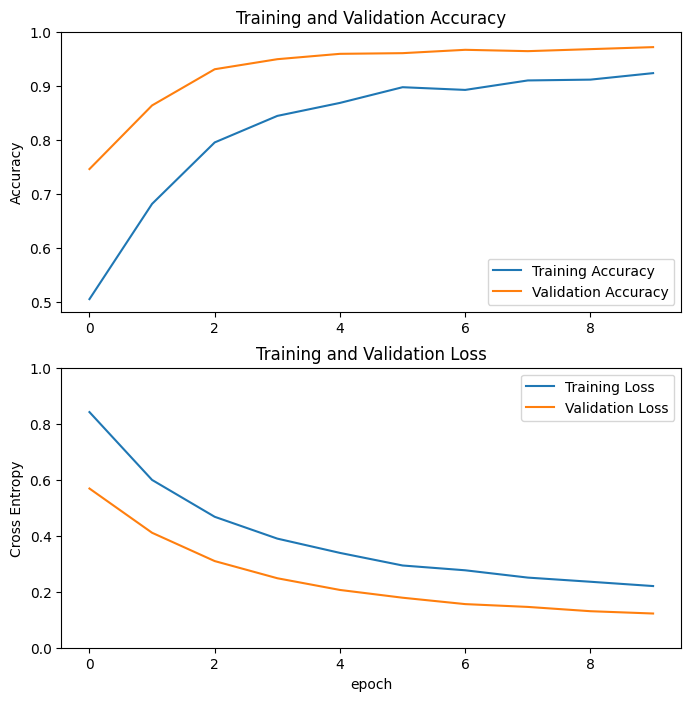

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

注意: 明らかに検証指標がトレーニング指標よりも優れていることを疑問に思われるかもしれませんが、それはトレーニング中に `tf.keras.layer.BatchNormalization` や `tf.keras.layer.Dropout` などのレイヤーが精度に影響を与えていることが主な要因です。検証損失の計算時には、これらのレイヤーはオフになっています。

また、上記の要因ほどではないにせよトレーニング指標がエポックの平均を報告する一方で検証指標がエポック後に評価されるため、検証指標の方が少しだけ長い時間トレーニングされたモデルを参照しているという理由もあります。

## ファインチューニング

特徴抽出の実験では、MobileNet V2 基本モデル上に少数のレイヤーを重ねてトレーニングをしたに過ぎませんでした。事前トレーニング済みネットワークの重みはトレーニング中に更新**されません**。

パフォーマンスをさらに向上させる方法の 1 つに、追加した分類器のトレーニングと並行して、事前トレーニング済みモデルの最上位レイヤーの重みをトレーニング（または「ファインチューニング」）するというものがあります。トレーニングのプロセスでは、一般的な特徴マップから特にデータセットに関連付けられた特徴に、強制的に重みをチューニングします。

注意: これは必ず、事前トレーニング済みモデルをトレーニング不可に設定し、最上位の分類器をトレーニングした後に行うようにしてください。事前トレーニング済みモデルの上にランダムに初期化された分類器を追加してすべてのレイヤーを結合トレーニングしようとすると、（分類器からのランダムな重みにより）勾配の更新規模が大きすぎて、事前トレーニング済みモデルが学習したことを忘れてしまいます。

また、MobileNet モデル全体ではなく、少数の最上位レイヤーをファインチューニングしてみることをお勧めします。大部分の畳み込みネットワークでは、上位のレイヤーに行くほど専門性が高くなります。最初の数レイヤーは、ほとんどすべてのタイプの画像に一般化する、非常に単純かつ一般的な特徴を学習します。上位のレイヤーに行くに従って、特徴はモデルがトレーニングされたデータセットに対してもっと固有なものになっていきます。ファインチューニングの目的は、一般的な学習を上書きするのではなく、これらの特殊な特徴に適応させて新しいデータセットで作業ができるようにすることです。

### モデルの最上位レイヤーを解凍する


ここでは `base_model` を解凍して、最下位レイヤーをトレーニング不可設定にするだけです。その後、モデルを再コンパイルして（これは行った変更を有効化するために必要）、トレーニングを再開します。

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### モデルをコンパイルする

かなり大規模なモデルをトレーニングしているため、事前トレーニング済みの重みを再適用する場合は、この段階では低い学習率を使用することが重要です。そうしなければ、モデルがすぐに過適合を起こす可能性があります。

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [32]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1862721 (7.11 MB)


Non-trainable params: 396544 (1.51 MB)


_________________________________________________________________


In [33]:
len(model.trainable_variables)

56

### モデルのトレーニングを続ける

前に収束するようにトレーニングをした場合は、このステップを踏むと精度が数ポイント向上します。

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 7:54 - loss: 0.2614 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.2385 - accuracy: 0.9271  

 5/63 [=>............................] - ETA: 2s - loss: 0.2805 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 2s - loss: 0.2475 - accuracy: 0.9196

 9/63 [===>..........................] - ETA: 2s - loss: 0.2250 - accuracy: 0.9271

11/63 [====>.........................] - ETA: 2s - loss: 0.2030 - accuracy: 0.9318

13/63 [=====>........................] - ETA: 1s - loss: 0.1950 - accuracy: 0.9327

15/63 [======>.......................] - ETA: 1s - loss: 0.2001 - accuracy: 0.9292

17/63 [=======>......................] - ETA: 1s - loss: 0.2010 - accuracy: 0.9283

19/63 [========>.....................] - ETA: 1s - loss: 0.1974 - accuracy: 0.9260

21/63 [=========>....................] - ETA: 1s - loss: 0.1910 - accuracy: 0.9301

23/63 [=========>....................] - ETA: 1s - loss: 0.1871 - accuracy: 0.9321

25/63 [==========>...................] - ETA: 1s - loss: 0.1800 - accuracy: 0.9350

27/63 [===========>..................] - ETA: 1s - loss: 0.1738 - accuracy: 0.9375

29/63 [============>.................] - ETA: 1s - loss: 0.1699 - accuracy: 0.9397

31/63 [=============>................] - ETA: 1s - loss: 0.1687 - accuracy: 0.9385

33/63 [==============>...............] - ETA: 1s - loss: 0.1663 - accuracy: 0.9394

35/63 [===============>..............] - ETA: 1s - loss: 0.1665 - accuracy: 0.9402

37/63 [================>.............] - ETA: 0s - loss: 0.1630 - accuracy: 0.9400

39/63 [=================>............] - ETA: 0s - loss: 0.1606 - accuracy: 0.9415

41/63 [==================>...........] - ETA: 0s - loss: 0.1574 - accuracy: 0.9428

43/63 [===================>..........] - ETA: 0s - loss: 0.1537 - accuracy: 0.9440

45/63 [====================>.........] - ETA: 0s - loss: 0.1511 - accuracy: 0.9451

47/63 [=====================>........] - ETA: 0s - loss: 0.1507 - accuracy: 0.9435

49/63 [======================>.......] - ETA: 0s - loss: 0.1552 - accuracy: 0.9420

51/63 [=======================>......] - ETA: 0s - loss: 0.1558 - accuracy: 0.9424

53/63 [========================>.....] - ETA: 0s - loss: 0.1535 - accuracy: 0.9428

55/63 [=========================>....] - ETA: 0s - loss: 0.1530 - accuracy: 0.9432

57/63 [==========================>...] - ETA: 0s - loss: 0.1516 - accuracy: 0.9446

59/63 [===========================>..] - ETA: 0s - loss: 0.1516 - accuracy: 0.9439

61/63 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9431

63/63 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9415

63/63 [==============================] - 12s 65ms/step - loss: 0.1529 - accuracy: 0.9415 - val_loss: 0.0578 - val_accuracy: 0.9802


Epoch 11/20


 1/63 [..............................] - ETA: 4s - loss: 0.2699 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 2s - loss: 0.1626 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 2s - loss: 0.1313 - accuracy: 0.9250

 7/63 [==>...........................] - ETA: 1s - loss: 0.1315 - accuracy: 0.9330

 9/63 [===>..........................] - ETA: 1s - loss: 0.1420 - accuracy: 0.9271

11/63 [====>.........................] - ETA: 1s - loss: 0.1302 - accuracy: 0.9318

13/63 [=====>........................] - ETA: 1s - loss: 0.1249 - accuracy: 0.9351

15/63 [======>.......................] - ETA: 1s - loss: 0.1265 - accuracy: 0.9396

17/63 [=======>......................] - ETA: 1s - loss: 0.1228 - accuracy: 0.9412

19/63 [========>.....................] - ETA: 1s - loss: 0.1234 - accuracy: 0.9408

21/63 [=========>....................] - ETA: 1s - loss: 0.1248 - accuracy: 0.9420

23/63 [=========>....................] - ETA: 1s - loss: 0.1214 - accuracy: 0.9443

25/63 [==========>...................] - ETA: 1s - loss: 0.1153 - accuracy: 0.9488

27/63 [===========>..................] - ETA: 1s - loss: 0.1126 - accuracy: 0.9502

29/63 [============>.................] - ETA: 1s - loss: 0.1098 - accuracy: 0.9515

31/63 [=============>................] - ETA: 1s - loss: 0.1085 - accuracy: 0.9526

33/63 [==============>...............] - ETA: 1s - loss: 0.1060 - accuracy: 0.9536

35/63 [===============>..............] - ETA: 0s - loss: 0.1045 - accuracy: 0.9554

37/63 [================>.............] - ETA: 0s - loss: 0.1044 - accuracy: 0.9561

39/63 [=================>............] - ETA: 0s - loss: 0.1022 - accuracy: 0.9567

41/63 [==================>...........] - ETA: 0s - loss: 0.1064 - accuracy: 0.9527

43/63 [===================>..........] - ETA: 0s - loss: 0.1071 - accuracy: 0.9528

45/63 [====================>.........] - ETA: 0s - loss: 0.1077 - accuracy: 0.9521

47/63 [=====================>........] - ETA: 0s - loss: 0.1093 - accuracy: 0.9521

49/63 [======================>.......] - ETA: 0s - loss: 0.1074 - accuracy: 0.9528

51/63 [=======================>......] - ETA: 0s - loss: 0.1046 - accuracy: 0.9547

53/63 [========================>.....] - ETA: 0s - loss: 0.1051 - accuracy: 0.9546

55/63 [=========================>....] - ETA: 0s - loss: 0.1031 - accuracy: 0.9551

57/63 [==========================>...] - ETA: 0s - loss: 0.1047 - accuracy: 0.9556

59/63 [===========================>..] - ETA: 0s - loss: 0.1053 - accuracy: 0.9550

61/63 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9559

63/63 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9555

63/63 [==============================] - 3s 45ms/step - loss: 0.1044 - accuracy: 0.9555 - val_loss: 0.0521 - val_accuracy: 0.9802


Epoch 12/20


 1/63 [..............................] - ETA: 4s - loss: 0.1136 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0649 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0784 - accuracy: 0.9750

 7/63 [==>...........................] - ETA: 1s - loss: 0.0799 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 1s - loss: 0.0954 - accuracy: 0.9653

11/63 [====>.........................] - ETA: 1s - loss: 0.0895 - accuracy: 0.9659

13/63 [=====>........................] - ETA: 1s - loss: 0.1000 - accuracy: 0.9639

15/63 [======>.......................] - ETA: 1s - loss: 0.1293 - accuracy: 0.9500

17/63 [=======>......................] - ETA: 1s - loss: 0.1247 - accuracy: 0.9522

19/63 [========>.....................] - ETA: 1s - loss: 0.1218 - accuracy: 0.9539

21/63 [=========>....................] - ETA: 1s - loss: 0.1151 - accuracy: 0.9568

23/63 [=========>....................] - ETA: 1s - loss: 0.1284 - accuracy: 0.9538

25/63 [==========>...................] - ETA: 1s - loss: 0.1362 - accuracy: 0.9500

27/63 [===========>..................] - ETA: 1s - loss: 0.1308 - accuracy: 0.9525

29/63 [============>.................] - ETA: 1s - loss: 0.1418 - accuracy: 0.9483

31/63 [=============>................] - ETA: 1s - loss: 0.1448 - accuracy: 0.9476

33/63 [==============>...............] - ETA: 1s - loss: 0.1396 - accuracy: 0.9498

35/63 [===============>..............] - ETA: 0s - loss: 0.1380 - accuracy: 0.9491

37/63 [================>.............] - ETA: 0s - loss: 0.1386 - accuracy: 0.9493

39/63 [=================>............] - ETA: 0s - loss: 0.1368 - accuracy: 0.9495

41/63 [==================>...........] - ETA: 0s - loss: 0.1379 - accuracy: 0.9497

43/63 [===================>..........] - ETA: 0s - loss: 0.1355 - accuracy: 0.9513

45/63 [====================>.........] - ETA: 0s - loss: 0.1381 - accuracy: 0.9493

47/63 [=====================>........] - ETA: 0s - loss: 0.1377 - accuracy: 0.9488

49/63 [======================>.......] - ETA: 0s - loss: 0.1331 - accuracy: 0.9509

51/63 [=======================>......] - ETA: 0s - loss: 0.1313 - accuracy: 0.9516

53/63 [========================>.....] - ETA: 0s - loss: 0.1306 - accuracy: 0.9517

55/63 [=========================>....] - ETA: 0s - loss: 0.1299 - accuracy: 0.9506

57/63 [==========================>...] - ETA: 0s - loss: 0.1289 - accuracy: 0.9512

59/63 [===========================>..] - ETA: 0s - loss: 0.1376 - accuracy: 0.9481

61/63 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9483

63/63 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9470

63/63 [==============================] - 3s 45ms/step - loss: 0.1369 - accuracy: 0.9470 - val_loss: 0.0438 - val_accuracy: 0.9827


Epoch 13/20


 1/63 [..............................] - ETA: 4s - loss: 0.1487 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.1056 - accuracy: 0.9479

 5/63 [=>............................] - ETA: 2s - loss: 0.0858 - accuracy: 0.9563

 7/63 [==>...........................] - ETA: 1s - loss: 0.1179 - accuracy: 0.9554

 9/63 [===>..........................] - ETA: 1s - loss: 0.1113 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 1s - loss: 0.1100 - accuracy: 0.9574

13/63 [=====>........................] - ETA: 1s - loss: 0.1134 - accuracy: 0.9567

15/63 [======>.......................] - ETA: 1s - loss: 0.1101 - accuracy: 0.9563

17/63 [=======>......................] - ETA: 1s - loss: 0.1098 - accuracy: 0.9577

19/63 [========>.....................] - ETA: 1s - loss: 0.1102 - accuracy: 0.9572

21/63 [=========>....................] - ETA: 1s - loss: 0.1046 - accuracy: 0.9598

23/63 [=========>....................] - ETA: 1s - loss: 0.1001 - accuracy: 0.9606

25/63 [==========>...................] - ETA: 1s - loss: 0.0982 - accuracy: 0.9613

27/63 [===========>..................] - ETA: 1s - loss: 0.0994 - accuracy: 0.9606

29/63 [============>.................] - ETA: 1s - loss: 0.0973 - accuracy: 0.9623

31/63 [=============>................] - ETA: 1s - loss: 0.0952 - accuracy: 0.9637

33/63 [==============>...............] - ETA: 1s - loss: 0.0935 - accuracy: 0.9640

35/63 [===============>..............] - ETA: 0s - loss: 0.0912 - accuracy: 0.9643

37/63 [================>.............] - ETA: 0s - loss: 0.0902 - accuracy: 0.9645

39/63 [=================>............] - ETA: 0s - loss: 0.0925 - accuracy: 0.9647

41/63 [==================>...........] - ETA: 0s - loss: 0.0895 - accuracy: 0.9665

43/63 [===================>..........] - ETA: 0s - loss: 0.0878 - accuracy: 0.9666

45/63 [====================>.........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9653

47/63 [=====================>........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9654

49/63 [======================>.......] - ETA: 0s - loss: 0.0925 - accuracy: 0.9636

51/63 [=======================>......] - ETA: 0s - loss: 0.0941 - accuracy: 0.9638

53/63 [========================>.....] - ETA: 0s - loss: 0.0961 - accuracy: 0.9640

55/63 [=========================>....] - ETA: 0s - loss: 0.0963 - accuracy: 0.9648

57/63 [==========================>...] - ETA: 0s - loss: 0.0959 - accuracy: 0.9644

59/63 [===========================>..] - ETA: 0s - loss: 0.0972 - accuracy: 0.9640

61/63 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.9631

63/63 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9635

63/63 [==============================] - 3s 45ms/step - loss: 0.0976 - accuracy: 0.9635 - val_loss: 0.0412 - val_accuracy: 0.9827


Epoch 14/20


 1/63 [..............................] - ETA: 4s - loss: 0.0931 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.1089 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.1027 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0940 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 1s - loss: 0.1136 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 1s - loss: 0.1161 - accuracy: 0.9574

13/63 [=====>........................] - ETA: 1s - loss: 0.1238 - accuracy: 0.9543

15/63 [======>.......................] - ETA: 1s - loss: 0.1241 - accuracy: 0.9563

17/63 [=======>......................] - ETA: 1s - loss: 0.1178 - accuracy: 0.9577

19/63 [========>.....................] - ETA: 1s - loss: 0.1115 - accuracy: 0.9572

21/63 [=========>....................] - ETA: 1s - loss: 0.1080 - accuracy: 0.9583

23/63 [=========>....................] - ETA: 1s - loss: 0.1180 - accuracy: 0.9538

25/63 [==========>...................] - ETA: 1s - loss: 0.1220 - accuracy: 0.9525

27/63 [===========>..................] - ETA: 1s - loss: 0.1171 - accuracy: 0.9560

29/63 [============>.................] - ETA: 1s - loss: 0.1153 - accuracy: 0.9558

31/63 [=============>................] - ETA: 1s - loss: 0.1111 - accuracy: 0.9577

33/63 [==============>...............] - ETA: 1s - loss: 0.1115 - accuracy: 0.9564

35/63 [===============>..............] - ETA: 0s - loss: 0.1124 - accuracy: 0.9571

37/63 [================>.............] - ETA: 0s - loss: 0.1092 - accuracy: 0.9586

39/63 [=================>............] - ETA: 0s - loss: 0.1051 - accuracy: 0.9607

41/63 [==================>...........] - ETA: 0s - loss: 0.1060 - accuracy: 0.9596

43/63 [===================>..........] - ETA: 0s - loss: 0.1045 - accuracy: 0.9593

45/63 [====================>.........] - ETA: 0s - loss: 0.1057 - accuracy: 0.9576

47/63 [=====================>........] - ETA: 0s - loss: 0.1074 - accuracy: 0.9561

49/63 [======================>.......] - ETA: 0s - loss: 0.1048 - accuracy: 0.9573

51/63 [=======================>......] - ETA: 0s - loss: 0.1028 - accuracy: 0.9577

53/63 [========================>.....] - ETA: 0s - loss: 0.1076 - accuracy: 0.9558

55/63 [=========================>....] - ETA: 0s - loss: 0.1061 - accuracy: 0.9568

57/63 [==========================>...] - ETA: 0s - loss: 0.1046 - accuracy: 0.9578

59/63 [===========================>..] - ETA: 0s - loss: 0.1057 - accuracy: 0.9582

61/63 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9580

63/63 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9585

63/63 [==============================] - 3s 45ms/step - loss: 0.1046 - accuracy: 0.9585 - val_loss: 0.0548 - val_accuracy: 0.9777


Epoch 15/20


 1/63 [..............................] - ETA: 4s - loss: 0.2173 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.1233 - accuracy: 0.9583

 5/63 [=>............................] - ETA: 2s - loss: 0.1036 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0845 - accuracy: 0.9732

 9/63 [===>..........................] - ETA: 1s - loss: 0.0865 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 1s - loss: 0.1298 - accuracy: 0.9574

13/63 [=====>........................] - ETA: 1s - loss: 0.1149 - accuracy: 0.9639

15/63 [======>.......................] - ETA: 1s - loss: 0.1065 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0997 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 1s - loss: 0.0948 - accuracy: 0.9704

21/63 [=========>....................] - ETA: 1s - loss: 0.0924 - accuracy: 0.9702

23/63 [=========>....................] - ETA: 1s - loss: 0.0920 - accuracy: 0.9701

25/63 [==========>...................] - ETA: 1s - loss: 0.0929 - accuracy: 0.9700

27/63 [===========>..................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9711

29/63 [============>.................] - ETA: 1s - loss: 0.0870 - accuracy: 0.9709

31/63 [=============>................] - ETA: 1s - loss: 0.0855 - accuracy: 0.9718

33/63 [==============>...............] - ETA: 1s - loss: 0.0831 - accuracy: 0.9725

35/63 [===============>..............] - ETA: 0s - loss: 0.0837 - accuracy: 0.9723

37/63 [================>.............] - ETA: 0s - loss: 0.0815 - accuracy: 0.9730

39/63 [=================>............] - ETA: 0s - loss: 0.0837 - accuracy: 0.9712

41/63 [==================>...........] - ETA: 0s - loss: 0.0811 - accuracy: 0.9726

43/63 [===================>..........] - ETA: 0s - loss: 0.0796 - accuracy: 0.9731

45/63 [====================>.........] - ETA: 0s - loss: 0.0806 - accuracy: 0.9715

47/63 [=====================>........] - ETA: 0s - loss: 0.0827 - accuracy: 0.9701

49/63 [======================>.......] - ETA: 0s - loss: 0.0831 - accuracy: 0.9700

51/63 [=======================>......] - ETA: 0s - loss: 0.0826 - accuracy: 0.9700

53/63 [========================>.....] - ETA: 0s - loss: 0.0810 - accuracy: 0.9705

55/63 [=========================>....] - ETA: 0s - loss: 0.0807 - accuracy: 0.9705

57/63 [==========================>...] - ETA: 0s - loss: 0.0798 - accuracy: 0.9709

59/63 [===========================>..] - ETA: 0s - loss: 0.0788 - accuracy: 0.9714

61/63 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9713

63/63 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9715

63/63 [==============================] - 3s 45ms/step - loss: 0.0783 - accuracy: 0.9715 - val_loss: 0.0370 - val_accuracy: 0.9864


Epoch 16/20


 1/63 [..............................] - ETA: 4s - loss: 0.0319 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.1096 - accuracy: 0.9583

 5/63 [=>............................] - ETA: 2s - loss: 0.0954 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.1071 - accuracy: 0.9598

 9/63 [===>..........................] - ETA: 1s - loss: 0.1115 - accuracy: 0.9549

11/63 [====>.........................] - ETA: 1s - loss: 0.0987 - accuracy: 0.9602

13/63 [=====>........................] - ETA: 1s - loss: 0.0949 - accuracy: 0.9639

15/63 [======>.......................] - ETA: 1s - loss: 0.0957 - accuracy: 0.9646

17/63 [=======>......................] - ETA: 1s - loss: 0.0973 - accuracy: 0.9614

19/63 [========>.....................] - ETA: 1s - loss: 0.0960 - accuracy: 0.9622

21/63 [=========>....................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9628

23/63 [=========>....................] - ETA: 1s - loss: 0.0882 - accuracy: 0.9647

25/63 [==========>...................] - ETA: 1s - loss: 0.0849 - accuracy: 0.9650

27/63 [===========>..................] - ETA: 1s - loss: 0.0830 - accuracy: 0.9664

29/63 [============>.................] - ETA: 1s - loss: 0.0843 - accuracy: 0.9666

31/63 [=============>................] - ETA: 1s - loss: 0.0834 - accuracy: 0.9677

33/63 [==============>...............] - ETA: 1s - loss: 0.0812 - accuracy: 0.9688

35/63 [===============>..............] - ETA: 0s - loss: 0.0778 - accuracy: 0.9705

37/63 [================>.............] - ETA: 0s - loss: 0.0774 - accuracy: 0.9713

39/63 [=================>............] - ETA: 0s - loss: 0.0771 - accuracy: 0.9720

41/63 [==================>...........] - ETA: 0s - loss: 0.0797 - accuracy: 0.9695

43/63 [===================>..........] - ETA: 0s - loss: 0.0783 - accuracy: 0.9695

45/63 [====================>.........] - ETA: 0s - loss: 0.0776 - accuracy: 0.9694

47/63 [=====================>........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 0s - loss: 0.0774 - accuracy: 0.9700

51/63 [=======================>......] - ETA: 0s - loss: 0.0764 - accuracy: 0.9712

53/63 [========================>.....] - ETA: 0s - loss: 0.0753 - accuracy: 0.9717

55/63 [=========================>....] - ETA: 0s - loss: 0.0740 - accuracy: 0.9727

57/63 [==========================>...] - ETA: 0s - loss: 0.0744 - accuracy: 0.9731

59/63 [===========================>..] - ETA: 0s - loss: 0.0756 - accuracy: 0.9719

61/63 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9708

63/63 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9695

63/63 [==============================] - 3s 45ms/step - loss: 0.0801 - accuracy: 0.9695 - val_loss: 0.0335 - val_accuracy: 0.9876


Epoch 17/20


 1/63 [..............................] - ETA: 4s - loss: 0.0440 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0244 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0309 - accuracy: 0.9875

 7/63 [==>...........................] - ETA: 1s - loss: 0.0528 - accuracy: 0.9821

 9/63 [===>..........................] - ETA: 1s - loss: 0.0596 - accuracy: 0.9722

11/63 [====>.........................] - ETA: 1s - loss: 0.0562 - accuracy: 0.9744

13/63 [=====>........................] - ETA: 1s - loss: 0.0568 - accuracy: 0.9760

15/63 [======>.......................] - ETA: 1s - loss: 0.0546 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 1s - loss: 0.0551 - accuracy: 0.9798

19/63 [========>.....................] - ETA: 1s - loss: 0.0577 - accuracy: 0.9770

21/63 [=========>....................] - ETA: 1s - loss: 0.0573 - accuracy: 0.9762

23/63 [=========>....................] - ETA: 1s - loss: 0.0577 - accuracy: 0.9755

25/63 [==========>...................] - ETA: 1s - loss: 0.0596 - accuracy: 0.9737

27/63 [===========>..................] - ETA: 1s - loss: 0.0611 - accuracy: 0.9711

29/63 [============>.................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9698

31/63 [=============>................] - ETA: 1s - loss: 0.0578 - accuracy: 0.9718

33/63 [==============>...............] - ETA: 1s - loss: 0.0558 - accuracy: 0.9735

35/63 [===============>..............] - ETA: 0s - loss: 0.0652 - accuracy: 0.9714

37/63 [================>.............] - ETA: 0s - loss: 0.0638 - accuracy: 0.9721

39/63 [=================>............] - ETA: 0s - loss: 0.0632 - accuracy: 0.9728

41/63 [==================>...........] - ETA: 0s - loss: 0.0625 - accuracy: 0.9726

43/63 [===================>..........] - ETA: 0s - loss: 0.0640 - accuracy: 0.9724

45/63 [====================>.........] - ETA: 0s - loss: 0.0649 - accuracy: 0.9729

47/63 [=====================>........] - ETA: 0s - loss: 0.0688 - accuracy: 0.9721

49/63 [======================>.......] - ETA: 0s - loss: 0.0697 - accuracy: 0.9719

51/63 [=======================>......] - ETA: 0s - loss: 0.0703 - accuracy: 0.9712

53/63 [========================>.....] - ETA: 0s - loss: 0.0683 - accuracy: 0.9723

55/63 [=========================>....] - ETA: 0s - loss: 0.0699 - accuracy: 0.9710

57/63 [==========================>...] - ETA: 0s - loss: 0.0685 - accuracy: 0.9720

59/63 [===========================>..] - ETA: 0s - loss: 0.0674 - accuracy: 0.9725

61/63 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9718

63/63 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9715

63/63 [==============================] - 3s 45ms/step - loss: 0.0689 - accuracy: 0.9715 - val_loss: 0.0350 - val_accuracy: 0.9876


Epoch 18/20


 1/63 [..............................] - ETA: 4s - loss: 0.1823 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0912 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0861 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 1s - loss: 0.0858 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 1s - loss: 0.0764 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 1s - loss: 0.0770 - accuracy: 0.9773

13/63 [=====>........................] - ETA: 1s - loss: 0.0734 - accuracy: 0.9784

15/63 [======>.......................] - ETA: 1s - loss: 0.0666 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 1s - loss: 0.0646 - accuracy: 0.9779

19/63 [========>.....................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9737

21/63 [=========>....................] - ETA: 1s - loss: 0.0739 - accuracy: 0.9717

23/63 [=========>....................] - ETA: 1s - loss: 0.0691 - accuracy: 0.9742

25/63 [==========>...................] - ETA: 1s - loss: 0.0645 - accuracy: 0.9762

27/63 [===========>..................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9769

29/63 [============>.................] - ETA: 1s - loss: 0.0597 - accuracy: 0.9784

31/63 [=============>................] - ETA: 1s - loss: 0.0570 - accuracy: 0.9798

33/63 [==============>...............] - ETA: 1s - loss: 0.0593 - accuracy: 0.9792

35/63 [===============>..............] - ETA: 0s - loss: 0.0601 - accuracy: 0.9777

37/63 [================>.............] - ETA: 0s - loss: 0.0585 - accuracy: 0.9780

39/63 [=================>............] - ETA: 0s - loss: 0.0562 - accuracy: 0.9792

41/63 [==================>...........] - ETA: 0s - loss: 0.0588 - accuracy: 0.9787

43/63 [===================>..........] - ETA: 0s - loss: 0.0576 - accuracy: 0.9797

45/63 [====================>.........] - ETA: 0s - loss: 0.0619 - accuracy: 0.9785

47/63 [=====================>........] - ETA: 0s - loss: 0.0616 - accuracy: 0.9781

49/63 [======================>.......] - ETA: 0s - loss: 0.0598 - accuracy: 0.9790

51/63 [=======================>......] - ETA: 0s - loss: 0.0594 - accuracy: 0.9786

53/63 [========================>.....] - ETA: 0s - loss: 0.0591 - accuracy: 0.9782

55/63 [=========================>....] - ETA: 0s - loss: 0.0600 - accuracy: 0.9773

57/63 [==========================>...] - ETA: 0s - loss: 0.0626 - accuracy: 0.9759

59/63 [===========================>..] - ETA: 0s - loss: 0.0627 - accuracy: 0.9756

61/63 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9744

63/63 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9745

63/63 [==============================] - 3s 45ms/step - loss: 0.0643 - accuracy: 0.9745 - val_loss: 0.0322 - val_accuracy: 0.9876


Epoch 19/20


 1/63 [..............................] - ETA: 4s - loss: 0.0433 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0606 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0635 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0578 - accuracy: 0.9732

 9/63 [===>..........................] - ETA: 1s - loss: 0.0610 - accuracy: 0.9722

11/63 [====>.........................] - ETA: 1s - loss: 0.0565 - accuracy: 0.9744

13/63 [=====>........................] - ETA: 1s - loss: 0.0526 - accuracy: 0.9760

15/63 [======>.......................] - ETA: 1s - loss: 0.0566 - accuracy: 0.9771

17/63 [=======>......................] - ETA: 1s - loss: 0.0613 - accuracy: 0.9724

19/63 [========>.....................] - ETA: 1s - loss: 0.0710 - accuracy: 0.9655

21/63 [=========>....................] - ETA: 1s - loss: 0.0703 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 1s - loss: 0.0667 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9712

27/63 [===========>..................] - ETA: 1s - loss: 0.0597 - accuracy: 0.9734

29/63 [============>.................] - ETA: 1s - loss: 0.0594 - accuracy: 0.9731

31/63 [=============>................] - ETA: 1s - loss: 0.0565 - accuracy: 0.9748

33/63 [==============>...............] - ETA: 1s - loss: 0.0561 - accuracy: 0.9744

35/63 [===============>..............] - ETA: 0s - loss: 0.0547 - accuracy: 0.9750

37/63 [================>.............] - ETA: 0s - loss: 0.0545 - accuracy: 0.9755

39/63 [=================>............] - ETA: 0s - loss: 0.0546 - accuracy: 0.9760

41/63 [==================>...........] - ETA: 0s - loss: 0.0545 - accuracy: 0.9764

43/63 [===================>..........] - ETA: 0s - loss: 0.0552 - accuracy: 0.9760

45/63 [====================>.........] - ETA: 0s - loss: 0.0588 - accuracy: 0.9750

47/63 [=====================>........] - ETA: 0s - loss: 0.0584 - accuracy: 0.9747

49/63 [======================>.......] - ETA: 0s - loss: 0.0579 - accuracy: 0.9745

51/63 [=======================>......] - ETA: 0s - loss: 0.0576 - accuracy: 0.9743

53/63 [========================>.....] - ETA: 0s - loss: 0.0589 - accuracy: 0.9735

55/63 [=========================>....] - ETA: 0s - loss: 0.0579 - accuracy: 0.9739

57/63 [==========================>...] - ETA: 0s - loss: 0.0564 - accuracy: 0.9748

59/63 [===========================>..] - ETA: 0s - loss: 0.0595 - accuracy: 0.9735

61/63 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9739

63/63 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9740

63/63 [==============================] - 3s 45ms/step - loss: 0.0586 - accuracy: 0.9740 - val_loss: 0.0462 - val_accuracy: 0.9827


Epoch 20/20


 1/63 [..............................] - ETA: 4s - loss: 0.0141 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0890 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.1115 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.0991 - accuracy: 0.9643

 9/63 [===>..........................] - ETA: 1s - loss: 0.1194 - accuracy: 0.9549

11/63 [====>.........................] - ETA: 1s - loss: 0.1068 - accuracy: 0.9602

13/63 [=====>........................] - ETA: 1s - loss: 0.1106 - accuracy: 0.9615

15/63 [======>.......................] - ETA: 1s - loss: 0.1037 - accuracy: 0.9646

17/63 [=======>......................] - ETA: 1s - loss: 0.0979 - accuracy: 0.9651

19/63 [========>.....................] - ETA: 1s - loss: 0.0909 - accuracy: 0.9671

21/63 [=========>....................] - ETA: 1s - loss: 0.0964 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 1s - loss: 0.0908 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 1s - loss: 0.0858 - accuracy: 0.9700

27/63 [===========>..................] - ETA: 1s - loss: 0.0885 - accuracy: 0.9676

29/63 [============>.................] - ETA: 1s - loss: 0.0883 - accuracy: 0.9677

31/63 [=============>................] - ETA: 1s - loss: 0.0859 - accuracy: 0.9688

33/63 [==============>...............] - ETA: 1s - loss: 0.0865 - accuracy: 0.9688

35/63 [===============>..............] - ETA: 0s - loss: 0.0830 - accuracy: 0.9696

37/63 [================>.............] - ETA: 0s - loss: 0.0875 - accuracy: 0.9688

39/63 [=================>............] - ETA: 0s - loss: 0.0865 - accuracy: 0.9688

41/63 [==================>...........] - ETA: 0s - loss: 0.0834 - accuracy: 0.9703

43/63 [===================>..........] - ETA: 0s - loss: 0.0803 - accuracy: 0.9717

45/63 [====================>.........] - ETA: 0s - loss: 0.0796 - accuracy: 0.9715

47/63 [=====================>........] - ETA: 0s - loss: 0.0787 - accuracy: 0.9714

49/63 [======================>.......] - ETA: 0s - loss: 0.0777 - accuracy: 0.9713

51/63 [=======================>......] - ETA: 0s - loss: 0.0804 - accuracy: 0.9694

53/63 [========================>.....] - ETA: 0s - loss: 0.0782 - accuracy: 0.9705

55/63 [=========================>....] - ETA: 0s - loss: 0.0766 - accuracy: 0.9716

57/63 [==========================>...] - ETA: 0s - loss: 0.0747 - accuracy: 0.9726

59/63 [===========================>..] - ETA: 0s - loss: 0.0734 - accuracy: 0.9730

61/63 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9723

63/63 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9725

63/63 [==============================] - 3s 45ms/step - loss: 0.0738 - accuracy: 0.9725 - val_loss: 0.0381 - val_accuracy: 0.9839


MobileNet V2 基本モデルの最後の数レイヤーをファインチューニングし、その上で分類器をトレーニングした場合の、トレーニングと検証それぞれの精度と損失の学習曲線を見てみましょう。検証損失の曲線がトレーニング損失よりもはるかに高いため、多少の過適合が発生する可能性があります。

また、新しいトレーニングセットが比較的小規模で、元の MobileNet V2 データセットに似ているために、過適合が発生する場合があります。


モデルをファインチューニングした後は、検証セットの精度はほぼ 98%に達します。

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

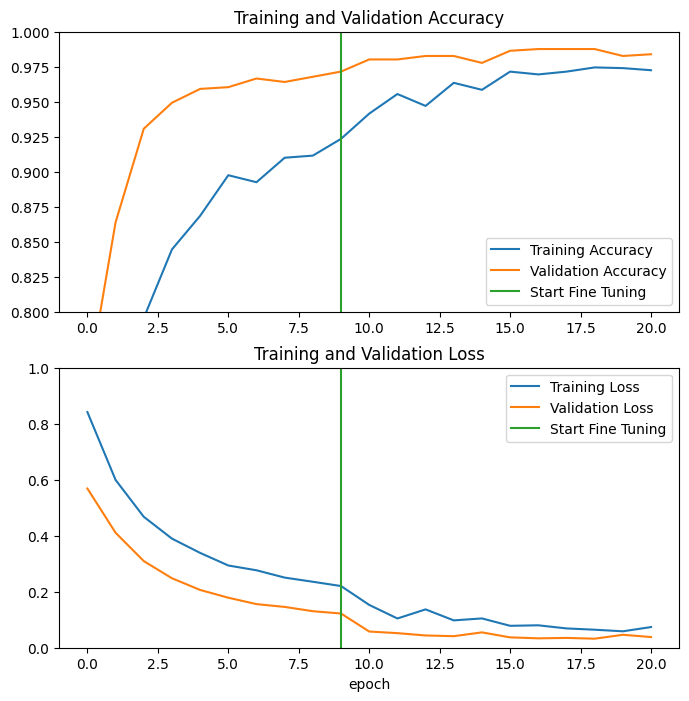

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 評価と予測をする

最後に、テストセットを使用して、新しいデータでモデルの性能を検証することができます。

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9688

4/6 [===================>..........] - ETA: 0s - loss: 0.0569 - accuracy: 0.9766

6/6 [==============================] - 0s 24ms/step - loss: 0.0398 - accuracy: 0.9844


Test accuracy : 0.984375


これで、このモデルを使用してペットが猫か犬かを予測する準備がすべて整いました。

Predictions:
 [0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1]
Labels:
 [0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1]


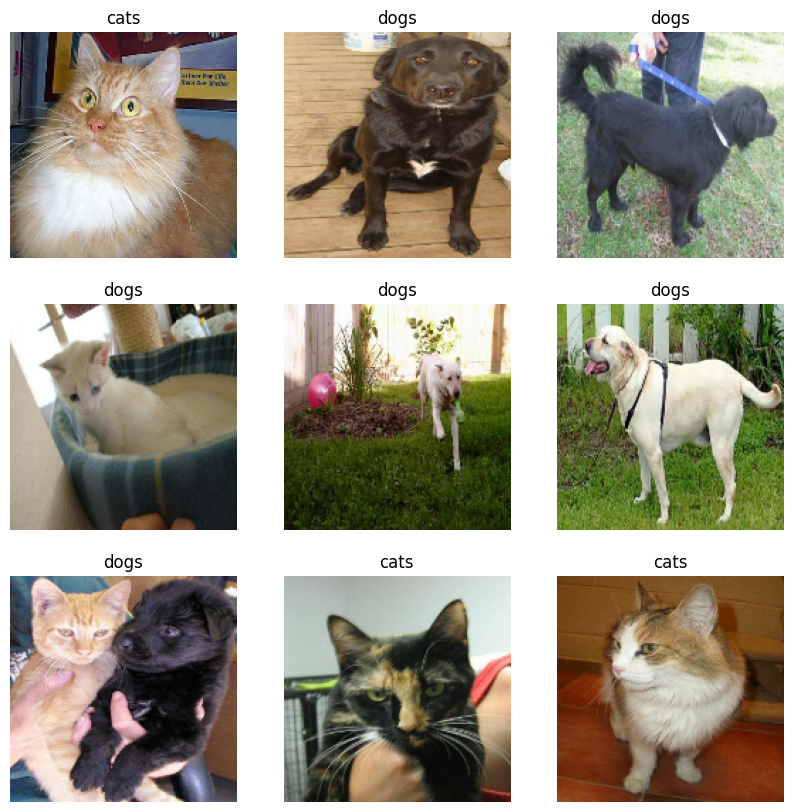

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 要約

- **特徴抽出に事前トレーニング済みモデルを使用する**:  小さなデータセットで作業する場合は、より大規模な同じドメインのデータセットでトレーニングされたモデルが学習した特徴を利用するのが一般的です。これは、事前トレーニング済みモデルをインスタンス化し、その上に完全に接続された分類器を追加して行います。事前トレーニング済みモデルは「凍結」されているため、トレーニング中は分類器の重みだけを更新します。この場合、畳み込みベースは各画像に関連付けられたすべての特徴を抽出し、抽出された特徴量のセットから画像クラスを決定する分類器をトレーニングします。

- **事前トレーニング済みモデルをファインチューニングする**: 性能をさらに向上させるために、事前トレーニング済みモデルの最上位レイヤーをファインチューニングして、新しいデータセットに再利用することができます。この場合は、データセット固有の高レベルの特徴をモデルが学習するように重みをチューニングします。この手法は、通常はトレーニングデータセットが大規模で、事前トレーニング済みモデルがトレーニングされた元のデータセットによく似ている場合に推奨されます。

さらに詳しくは[転移学習ガイド](https://www.tensorflow.org/guide/keras/transfer_learning)をご覧ください。
